### Make Configs

First, we generate a config file with paths to all the raw data. Each entry of the resulting yaml file specifies the source satellite image and the shapefiles over which to create masks.

In [27]:
from pathlib import Path

data_dir = Path("glacier_data/")

# label shape files
glaciers_file = data_dir / "vector_data/Glacier_2005.shp"
clean_g_file = data_dir / "vector_data/clean.shp"
debris_g_file =  data_dir / "vector_data/debris.shp"
border_file = data_dir / "vector_data/hkh.shp"

# directories for configuration and output
masking_file = "conf/masking_paths.yaml"
process_file = "conf/postprocess.yaml"
process_dir = data_dir / "processed"
output_dir = process_dir / "patches"
input_folder = data_dir / "raster_data"

In [2]:
SUBSET = False # set to False to run on full data

paths = {}
input_paths = list(Path(input_folder).glob("*.tif*"))
if SUBSET is not False:
    input_paths = input_paths[:SUBSET]

for i, f in enumerate(input_paths):
    mask_ele = {}
    mask_ele["img_path"] = str(f)
    mask_ele["mask_paths"] = [str(s) for s in [glaciers_file, clean_g_file, debris_g_file]]
    mask_ele["border_path"] = str(border_file )
    paths[f"mask_{i}"] = mask_ele

In [3]:
import yaml

with open(masking_file, 'w') as f:
    yaml.dump(paths, f, default_flow_style=False, sort_keys=False)

### Masking

Given the configuration file `masking_paths.yaml`, we can create numpy masks that are aligned with the underlying numpy images. You can see from the plot below that the four channels of the mask correspond to (1) all the glaciers, (2) the clean ice glaciers, (3) the debris-covered glaciers, and (4) the country masks.

In [4]:
from glacier_mapping.data.mask import generate_masks
import shutil

masking_paths = yaml.safe_load(open(masking_file))
img_paths = [p["img_path"] for p in masking_paths.values()]
mask_paths = [p["mask_paths"] for p in masking_paths.values()]
border_paths = [p["border_path"] for p in masking_paths.values()]
mask_dir = process_dir / "masks"

#if mask_dir.exists():
#    shutil.rmtree(mask_dir)
    
#generate_masks(img_paths, mask_paths, border_paths=border_paths, out_dir=mask_dir)

,id,img,mask,border,img_width,img_height,mask_width,mask_height
0,0,glacier_data\raster_data\LE07_134040_20070922.tif,glacier_data\processed\masks\mask_00.npy,glacier_data\processed\masks\border_00.npy,7927,7176,7927,7176
1,1,glacier_data\raster_data\LE07_135040_20081102.tif,glacier_data\processed\masks\mask_01.npy,glacier_data\processed\masks\border_01.npy,7730,6982,7730,6982
2,2,glacier_data\raster_data\LE07_136040_20060731.tif,glacier_data\processed\masks\mask_02.npy,glacier_data\processed\masks\border_02.npy,7777,7046,7777,7046
3,3,glacier_data\raster_data\LE07_136041_20060731.tif,glacier_data\processed\masks\mask_03.npy,glacier_data\processed\masks\border_03.npy,7817,7047,7817,7047
4,4,glacier_data\raster_data\LE07_137041_20060127.tif,glacier_data\processed\masks\mask_04.npy,glacier_data\processed\masks\border_04.npy,7858,7120,7858,7120


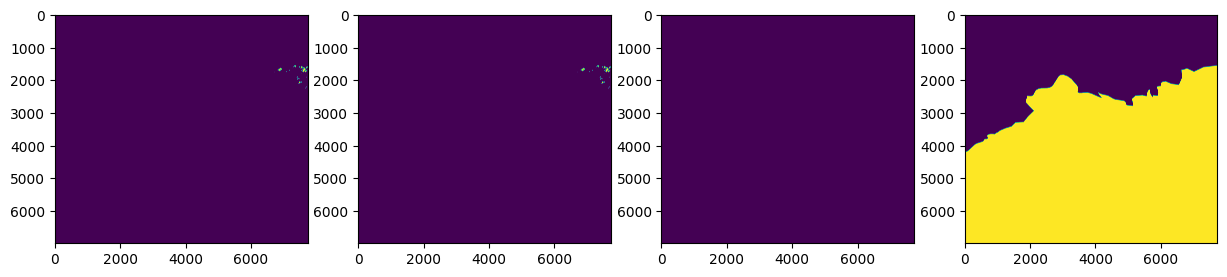

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

mask = np.load(mask_dir / "mask_01.npy")
border = np.load(mask_dir / "border_01.npy")
_, ax = plt.subplots(1, 4, figsize=(15, 15))
ax[0].imshow(mask[:, :, 0])
ax[1].imshow(mask[:, :, 1])
ax[2].imshow(mask[:, :, 2])
ax[3].imshow(border)

mask_df = pd.read_csv(mask_dir / "mask_metadata.csv")
mask_df.head()

### Patches

Once we have binary masks associated with each image, we can slice them into 512 x 512 patches to be used for training.

In [6]:
from glacier_mapping.data.slice import write_pair_slices

paths = pd.read_csv(mask_dir / "mask_metadata.csv")
output_dir.mkdir(parents=True, exist_ok=True)

metadata = []
for row in range(len(paths)):
    print(f"## Slicing tiff {row +1}/{len(paths)} ...")
    metadata_ = write_pair_slices(
        paths.iloc[row]["img"],
        paths.iloc[row]["mask"],
        output_dir,
        border_path=paths.iloc[row]["border"],
        out_base=f"patch_{paths.index[row]}"
    )
    metadata.append(metadata_)

metadata = pd.concat(metadata, axis=0)
out_path = Path(output_dir, "patches.geojson")
metadata.to_file(out_path, index=False, driver="GeoJSON")

## Slicing tiff 1/35 ...


100%|██████████| 210/210 [00:31<00:00,  6.58it/s]


## Slicing tiff 2/35 ...


100%|██████████| 195/195 [00:24<00:00,  7.88it/s]


## Slicing tiff 3/35 ...


100%|██████████| 195/195 [00:24<00:00,  8.08it/s]


## Slicing tiff 4/35 ...


100%|██████████| 195/195 [00:26<00:00,  7.40it/s]


## Slicing tiff 5/35 ...


100%|██████████| 210/210 [00:27<00:00,  7.60it/s]


## Slicing tiff 6/35 ...


100%|██████████| 195/195 [00:25<00:00,  7.72it/s]


## Slicing tiff 7/35 ...


100%|██████████| 195/195 [00:24<00:00,  8.03it/s]


## Slicing tiff 8/35 ...


100%|██████████| 195/195 [00:25<00:00,  7.71it/s]


## Slicing tiff 9/35 ...


100%|██████████| 195/195 [00:25<00:00,  7.72it/s]


## Slicing tiff 10/35 ...


100%|██████████| 195/195 [00:29<00:00,  6.64it/s]


## Slicing tiff 11/35 ...


100%|██████████| 210/210 [00:27<00:00,  7.77it/s]


## Slicing tiff 12/35 ...


100%|██████████| 210/210 [00:27<00:00,  7.56it/s]


## Slicing tiff 13/35 ...


100%|██████████| 210/210 [00:26<00:00,  7.78it/s]


## Slicing tiff 14/35 ...


100%|██████████| 210/210 [00:28<00:00,  7.47it/s]


## Slicing tiff 15/35 ...


100%|██████████| 210/210 [00:28<00:00,  7.42it/s]


## Slicing tiff 16/35 ...


100%|██████████| 210/210 [00:27<00:00,  7.50it/s]


## Slicing tiff 17/35 ...


100%|██████████| 195/195 [00:25<00:00,  7.73it/s]


## Slicing tiff 18/35 ...


100%|██████████| 195/195 [00:25<00:00,  7.79it/s]


## Slicing tiff 19/35 ...


100%|██████████| 195/195 [00:25<00:00,  7.79it/s]


## Slicing tiff 20/35 ...


100%|██████████| 195/195 [00:24<00:00,  7.94it/s]


## Slicing tiff 21/35 ...


100%|██████████| 195/195 [00:26<00:00,  7.50it/s]


## Slicing tiff 22/35 ...


100%|██████████| 195/195 [00:26<00:00,  7.48it/s]


## Slicing tiff 23/35 ...


100%|██████████| 210/210 [00:28<00:00,  7.44it/s]


## Slicing tiff 24/35 ...


100%|██████████| 210/210 [00:27<00:00,  7.57it/s]


## Slicing tiff 25/35 ...


100%|██████████| 210/210 [00:28<00:00,  7.31it/s]


## Slicing tiff 26/35 ...


100%|██████████| 210/210 [00:27<00:00,  7.63it/s]


## Slicing tiff 27/35 ...


100%|██████████| 210/210 [00:28<00:00,  7.42it/s]


## Slicing tiff 28/35 ...


100%|██████████| 210/210 [00:26<00:00,  7.86it/s]


## Slicing tiff 29/35 ...


100%|██████████| 210/210 [00:25<00:00,  8.17it/s]


## Slicing tiff 30/35 ...


100%|██████████| 210/210 [00:25<00:00,  8.17it/s]


## Slicing tiff 31/35 ...


100%|██████████| 210/210 [00:26<00:00,  8.07it/s]


## Slicing tiff 32/35 ...


100%|██████████| 195/195 [00:24<00:00,  7.81it/s]


## Slicing tiff 33/35 ...


100%|██████████| 195/195 [00:26<00:00,  7.26it/s]


## Slicing tiff 34/35 ...


100%|██████████| 195/195 [00:25<00:00,  7.65it/s]


## Slicing tiff 35/35 ...


100%|██████████| 210/210 [00:26<00:00,  7.82it/s]


ValueError: Cannot determine common CRS for concatenation inputs, got ['WGS 84 / UTM zone 47N', 'WGS 84 / UTM zone 46N', 'WGS 84 / UTM zone 45N', 'WGS 84 / UTM zone 44N', 'WGS 84 / UTM zone 43N', 'WGS 84 / UTM zone 42N']. Use `to_crs()` to transform geometries to the same CRS before merging.

In [19]:
#list(map(lambda x: x.to_crs(x.crs), metadata))


#metadata = pd.concat(list(map(lambda x: x.to_crs('WGS 84 / UTM zone 47N'), metadata)), axis=0)
out_path = Path(output_dir, "patches.geojson")
metadata.to_file(out_path, index=False, driver="GeoJSON")

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

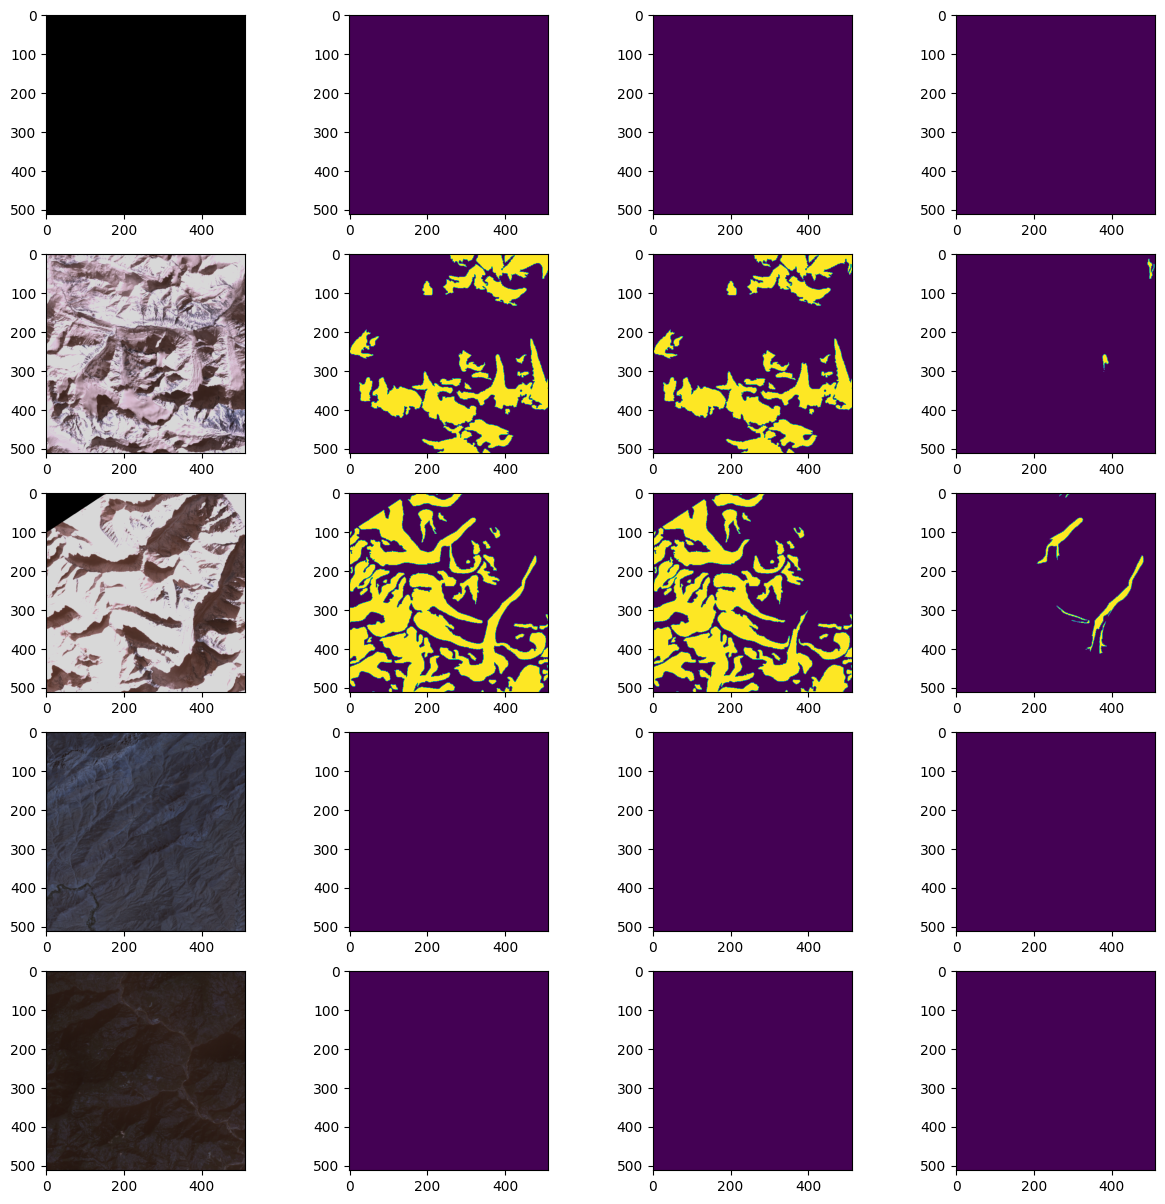

In [23]:
from glacier_mapping.data.slice import plot_slices
plot_slices(output_dir, n_cols=4, div=300)

### Split and filter

Now that we have sliced each tiff into small patches, we can determine which to use for training, validation, and testing. We first filter away those patches that have relatively little glacier, then we randomly shuffle them into train, dev, and test directories.

In [28]:
from addict import Dict
import geopandas as gpd
import glacier_mapping.data.process_slices_funs as pf
import yaml

pconf = Dict(yaml.safe_load(open(process_file, "r")))
slice_meta = gpd.read_file(output_dir / "patches.geojson")

# filter all the slices to the ones that matter
print("filtering")
keep_ids = pf.filter_directory(
    slice_meta,
    filter_perc=pconf.filter_percentage,
    filter_channel=pconf.filter_channel,
)

# validation: get ids for the ones that will be training vs. testing.
print("reshuffling")
split_method = [item for item in pconf.split_method.items()][0][0]
split_ratio = pconf.split_method[split_method].split_ratio
split_fun = getattr(pf, split_method)
split_ids = split_fun(keep_ids, split_ratio, slice_meta=slice_meta)
target_locs = pf.reshuffle(split_ids, process_dir)


filtering
reshuffling
shuffling image 0 - img
shuffling image 0 - mask
shuffling image 1 - img
shuffling image 1 - mask
shuffling image 2 - img
shuffling image 2 - mask
shuffling image 3 - img
shuffling image 3 - mask
shuffling image 4 - img
shuffling image 4 - mask
shuffling image 5 - img
shuffling image 5 - mask
shuffling image 6 - img
shuffling image 6 - mask
shuffling image 7 - img
shuffling image 7 - mask
shuffling image 8 - img
shuffling image 8 - mask
shuffling image 9 - img
shuffling image 9 - mask
shuffling image 10 - img
shuffling image 10 - mask
shuffling image 11 - img
shuffling image 11 - mask
shuffling image 12 - img
shuffling image 12 - mask
shuffling image 13 - img
shuffling image 13 - mask
shuffling image 14 - img
shuffling image 14 - mask
shuffling image 15 - img
shuffling image 15 - mask
shuffling image 16 - img
shuffling image 16 - mask
shuffling image 17 - img
shuffling image 17 - mask
shuffling image 18 - img
shuffling image 18 - mask
shuffling image 19 - img
shuf

For future reference, it's useful to save which patches went into which split. These will be contained in the `target_locks.pickle` file below.

In [29]:
import pickle
target_locs_file = process_dir / "target_locs.pickle"
with open(target_locs_file, "wb") as f:
    pickle.dump(target_locs, f, protocol=pickle.HIGHEST_PROTOCOL)

First, we have to postprocess the patches that have been selected for training. We normalize all the input channels and add a "background" output channel, to support multiclass classification. Next, we perform the normalization.

In [30]:
import glacier_mapping.data.process_slices_funs as pf

print("Normalizing input channels.")
stats = pf.generate_stats(
    [p["img"] for p in target_locs["train"]],
    pconf.normalization_sample_size,
    pconf.process_funs.normalize.stats_path,
)

Normalizing input channels.


We now complete any other postprocessing specified by the processing configuration file.

In [31]:
for split_type in target_locs:
    for k in range(len(target_locs[split_type])):
        img, mask = pf.postprocess(
            target_locs[split_type][k]["img"],
            target_locs[split_type][k]["mask"],
            pconf.process_funs,
        )
        
        np.save(target_locs[split_type][k]["img"], img)
        np.save(target_locs[split_type][k]["mask"], mask)